In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import pandas as pd
import seaborn as sns
import io #Used as buffer

# Read Data

In [2]:
path= Path(f'../../data/cluster_results')

In [3]:
def read_csv(f):
    df = pd.read_csv(f).mean()
    df['std'] = pd.read_csv(f).std().iloc[0] ##added line for std, remove this will remove std from table
    df['experiment'] = f.parent.parent.parent.name
    df['function'] = f.parent.parent.name
    name = f.parent.name
    #print(name)
    df['freq'] = float(name[4:].split('n')[0])
    #print(df['freq'])
    df['method'] = f.name.split('_')[0]+'_'+f.name.split('_')[1]
    #df['method'] = f.name.split('_')[0]
    #print(df['method'])
    return df

measure_name=['mof','sr','arr','nfe','nn_time']
index_measure=0

In [4]:
m = measure_name[index_measure]
files  = list(f for f in path.glob(f'exp*/*/freq*nn_p3nn_s3nn_tw5*bs4*/*{m}.csv') if 'NNnorm' in f.name)
# files += list(path.glob(f'exp*/*/*nn_p3/*{m}.csv'))
files += [f for f in path.glob(f'exp*/*/freq*nn_p3nn_s2nn_tw5*bs4*/*{m}.csv') if 'noNN' in f.name] #f'exp*/*/*nn_p3/*{m}.csv'  , 
#print(files)
df = pd.DataFrame([read_csv(f) for f in files])
df.rename({'0':m}, axis=1, inplace=True)
# data = pd.pivot_table(df, index=['experiment','function'], columns='method', values=m) #,'freq' later for adding frequency experiment
data = pd.pivot_table(df, index=['experiment','function','freq'],  columns='method') #,'freq' later for adding frequency experiment, ,values=m
data.style.format("{:,.2f}")

In [5]:
df.head()

,mof,std,experiment,function,freq,method
0,55.874118,4.817095,exp4,rastrigin,1.0,NNnorm_Random
1,54.480326,4.832268,exp4,rastrigin,1.0,NNnorm_Worst
2,27.647694,3.217041,exp4,rastrigin,4.0,NNnorm_Random
3,27.464060,3.287621,exp4,rastrigin,4.0,NNnorm_Worst
4,74.551251,5.971196,exp4,rastrigin,0.5,NNnorm_Random


In [6]:
def get_table_data(source, index, columns):
    lbl_dict = {'NNnorm_Worst' :'NNW',
                'NNnorm_Random':'NNR',
                'noNNReval'    :'noNN'}
    df = source.copy()
    df.function = df.function.str.title()
    df.method = df.method.apply(lambda x: lbl_dict[x])
    data = pd.pivot_table(df, index=index, columns=columns)
    m = data.columns.levels[0][0]
    # Add std to table
    final_data = data[m].copy()
    for col in data[m].columns:
        final_data[col] = data[m    ][col].apply(lambda x: f'{x:,.2f} (±') +\
                          data['std'][col].apply(lambda x: f'{x:,.2f})'  )
    
    final_data.sort_index(ascending=False, inplace=True)
    data[m].mean(axis=0)
    return final_data

In [7]:
' & '.join([str(o) for o in ss.to_frame().T.round(2).to_numpy().flatten().tolist()])

NameError: name 'ss' is not defined

In [8]:
table1 = get_table_data(df, index=['experiment','function','freq'], columns=['method']).head()
table1.head()

KeyError: 'noNNReval_mof.csv'

In [8]:
table2 = get_table_data(df, index=['function','method'], columns=['experiment','freq'])
table2.head()

experiment                 exp1                                      exp2  \
freq                        0.5           1.0           4.0           0.5   
function   method                                                           
Sphere     NNW     0.24 (±0.00)  0.11 (±0.00)  0.02 (±0.00)  0.25 (±0.00)   
           NNR     0.21 (±0.02)  0.12 (±0.03)  0.03 (±0.00)  0.22 (±0.03)   
Rosenbrock NNW     0.23 (±0.00)  0.12 (±0.00)  0.02 (±0.00)  0.22 (±0.00)   
           NNR     0.20 (±0.02)  0.12 (±0.02)  0.03 (±0.00)  0.21 (±0.02)   
Rastrigin  NNW     0.20 (±0.00)  0.14 (±0.00)  0.03 (±0.00)  0.20 (±0.00)   

experiment                                             exp3                \
freq                        1.0           4.0           0.5           1.0   
function   method                                                           
Sphere     NNW     0.10 (±0.00)  0.03 (±0.00)  0.24 (±0.00)  0.12 (±0.00)   
           NNR     0.12 (±0.01)  0.03 (±0.00)  0.24 (±0.01)  0.11 (±0.00)   
Rosenbrock NNW     0.11 (±0.00)  0.02 (±0.00)  0.23 (±0.00)  0.11 (±0.00)   
           NNR     0.12 (±0.01)  0.03 (±0.00)  0.24 (±0.01)  0.11 (±0.00)   
Rastrigin  NNW     0.12 (±0.00)  0.03 (±0.00)  0.24 (±0.00)  0.13 (±0.01)   

experiment                               exp4                              
freq                        4.0           0.5           1.0           4.0  
function   method                                                          
Sphere     NNW     0.03 (±0.00)  0.19 (±0.00)  0.10 (±0.00)  0.03 (±0.00)  
           NNR     0.03 (±0.00)  0.19 (±0.00)  0.12 (±0.00)  0.02 (±0.00)  
Rosenbrock NNW     0.03 (±0.00)  0.22 (±0.00)  0.11 (±0.00)  0.02 (±0.00)  
           NNR     0.03 (±0.00)  0.19 (±0.01)  0.12 (±0.00)  0.03 (±0.00)  
Rastrigin  NNW     0.03 (±0.00)  0.19 (±0.00)  0.11 (±0.00)  0.03 (±0.00)

# Latex

In [100]:
print(table2.to_csv(float_format='%.2f'))

experiment,,exp1,exp1,exp1,exp2,exp2,exp2,exp3,exp3,exp3,exp4,exp4,exp4
freq,,0.5,1.0,4.0,0.5,1.0,4.0,0.5,1.0,4.0,0.5,1.0,4.0
function,method,,,,,,,,,,,,
Sphere,NNW,0.24 (±0.00),0.11 (±0.00),0.02 (±0.00),0.25 (±0.00),0.10 (±0.00),0.03 (±0.00),0.24 (±0.00),0.12 (±0.00),0.03 (±0.00),0.19 (±0.00),0.10 (±0.00),0.03 (±0.00)
Sphere,NNR,0.21 (±0.02),0.12 (±0.03),0.03 (±0.00),0.22 (±0.03),0.12 (±0.01),0.03 (±0.00),0.24 (±0.01),0.11 (±0.00),0.03 (±0.00),0.19 (±0.00),0.12 (±0.00),0.02 (±0.00)
Rosenbrock,NNW,0.23 (±0.00),0.12 (±0.00),0.02 (±0.00),0.22 (±0.00),0.11 (±0.00),0.02 (±0.00),0.23 (±0.00),0.11 (±0.00),0.03 (±0.00),0.22 (±0.00),0.11 (±0.00),0.02 (±0.00)
Rosenbrock,NNR,0.20 (±0.02),0.12 (±0.02),0.03 (±0.00),0.21 (±0.02),0.12 (±0.01),0.03 (±0.00),0.24 (±0.01),0.11 (±0.00),0.03 (±0.00),0.19 (±0.01),0.12 (±0.00),0.03 (±0.00)
Rastrigin,NNW,0.20 (±0.00),0.14 (±0.00),0.03 (±0.00),0.20 (±0.00),0.12 (±0.00),0.03 (±0.00),0.24 (±0.00),0.13 (±0.01),0.03 (±0.00),0.19 (±0.00),0.11 (±0.00),0.03 (±0.00)


# Plots

In [7]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [8]:
# DataFrame we use for plots
d = data.reset_index()
d.columns = ['experiment', 'function', 'freq', 'NNR', 'NNW', 'noNN', 'NNR_std', 'NNW_std', 'noNN_std']
d.head(2)

,experiment,function,freq,NNR,NNW,noNN,NNR_std,NNW_std,noNN_std
0,exp1,rastrigin,0.5,16.039956,16.588359,20.235166,1.095591,0.179049,0.059278
1,exp1,rastrigin,1.0,15.988948,16.486775,22.465063,0.435917,0.152392,0.079311


In [9]:
d1 = d.melt(['experiment','function','freq'], value_vars=['NNR', 'NNW', 'noNN'],
            var_name='method', value_name='mof')
d2 = d.melt(['experiment','function','freq'], value_vars=['NNR_std', 'NNW_std', 'noNN_std'],
            var_name='method', value_name='mof_std')
d2.method = d2.method.str.replace('_std', '')
d = d1.merge(d2)
#d.head()

In [13]:
# test = d.query("experiment=='exp1' & freq==1").copy()
# mins = test.groupby('function')['mof'].min()
# mins

## Plots 0

In [9]:
test = d.query("experiment=='exp4'").copy()  # & freq==1"
mins = test.groupby('function')['mof'].min()
test['mof_norm'] = test['mof']
for k,v in mins.iteritems():
    test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
#test.head()

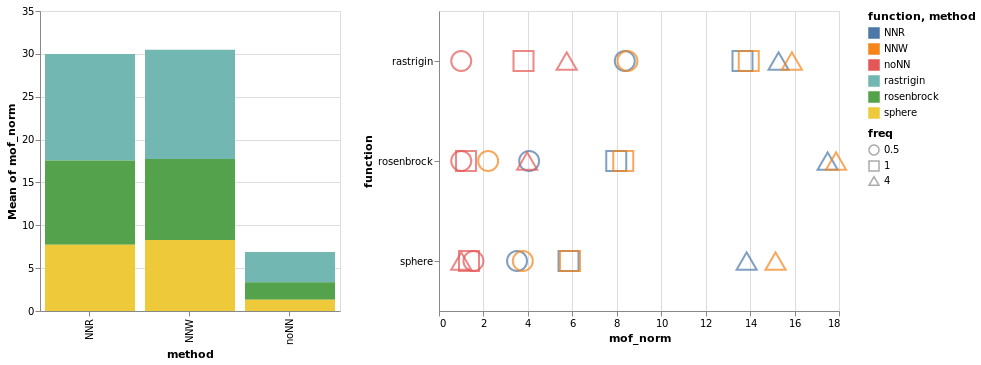

In [14]:
base = alt.Chart(test)
selector1 = alt.selection_single(fields=['method'])

chart1 = base.mark_bar().encode(
    alt.X('method'),
    alt.Y('mean(mof_norm)'),
    alt.Color('function'),
    opacity = alt.condition(selector1, alt.OpacityValue(1.0), alt.OpacityValue(0.1))
).properties(
    width=300
).add_selection(selector1)

chart2 = base.mark_point(size=400).encode(
    alt.X('mof_norm'),
    alt.Y('function'),
    alt.Color('method'),#function
    alt.Shape('freq:N'),
    alt.Tooltip(['mof_norm:Q','mof:Q','freq:Q','function:N'])
).transform_filter(
    selector1
).properties(
#     width=200
    height=300
)

chart1|chart2

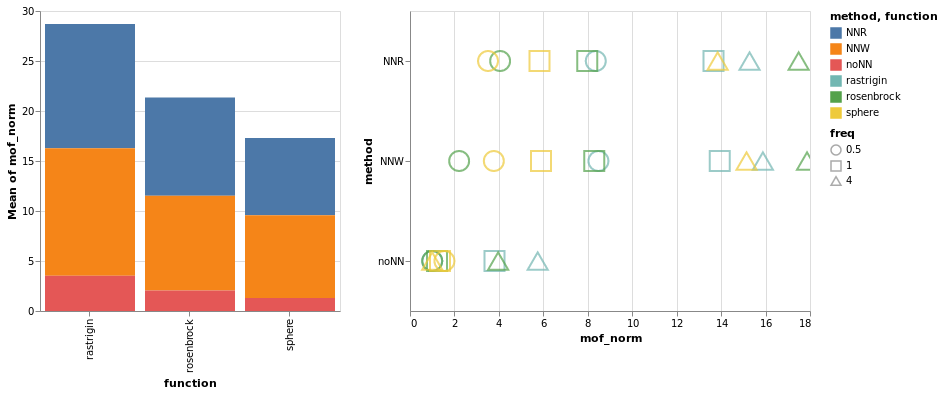

In [16]:
base = alt.Chart(test)
selector1 = alt.selection_single(fields=['function'])

chart1 = base.mark_bar().encode(
    alt.X('function'),
    alt.Y('mean(mof_norm)'),
    alt.Color('method'),
    opacity = alt.condition(selector1, alt.OpacityValue(1.0), alt.OpacityValue(0.1))
).properties(
    width=300
).add_selection(selector1)

chart2 = base.mark_point(size=400).encode(
    alt.X('mof_norm'),
    alt.Y('method'),
    alt.Color('function'),
    alt.Shape('freq:N'),
#     alt.Tooltip(['mof_norm','mof','freq','function'])
).transform_filter(
    selector1
).properties(
#     width=200
    height=300
)

chart1|chart2.interactive()

## plot 1

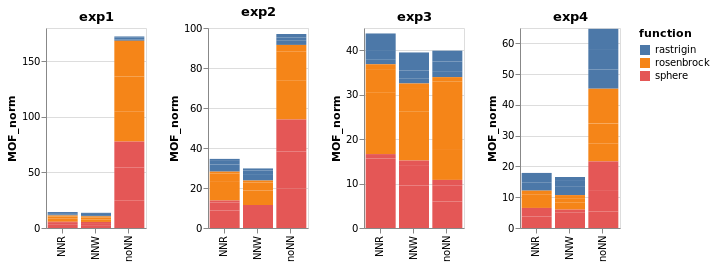

In [10]:
def plot_experiment_onlybars(exp):   
    test = d.query(f"experiment=={exp!r}").copy()
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
    
    base = alt.Chart(test)
    chart1 = base.mark_bar().encode(
        alt.X('method', title=''),
        alt.Y('mean(mof_norm)', title='MOF_norm'),
        alt.Color('function'),
        alt.Tooltip(['mof:Q','mof_norm:Q','function:N']),
#         alt.Column('function', title=''),
    ).properties(
        width=100, height=200, title=exp
    )
    return chart1

chart = (plot_experiment_onlybars('exp1') |
         plot_experiment_onlybars('exp2') |
         plot_experiment_onlybars('exp3') |
         plot_experiment_onlybars('exp4'))
chart.save(str(path/'chartAll.png'), scale_factor=2.0)
chart

In [19]:
def plot_experiment(exp):   
    test = d.query(f"experiment=={exp!r}").copy()
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v
    
    base = alt.Chart(test)
    selector1 = alt.selection_single(fields=['method'])

    chart1 = base.mark_bar().encode(
        alt.X('method', title=''),
        alt.Y('mean(mof_norm)', title=f'{exp} (mof_norm)'),
        alt.Color('function'),
#         alt.Column('function', title=''),
        opacity = alt.condition(selector1, alt.OpacityValue(1.0), alt.OpacityValue(0.1))
    ).properties(
        width=50, height=200
    ).add_selection(selector1)

    chart2 = base.mark_point(size=400).encode(
        alt.X('mof_norm'),
        alt.Y('function', title=''),
        alt.Color('method'),#function
        alt.Shape('freq:N'),
#         alt.Tooltip(['mof_norm','mof','freq','function'])
    ).transform_filter(
        selector1
    ).properties(
        width=200, height=200
    )

    return chart1|chart2
    

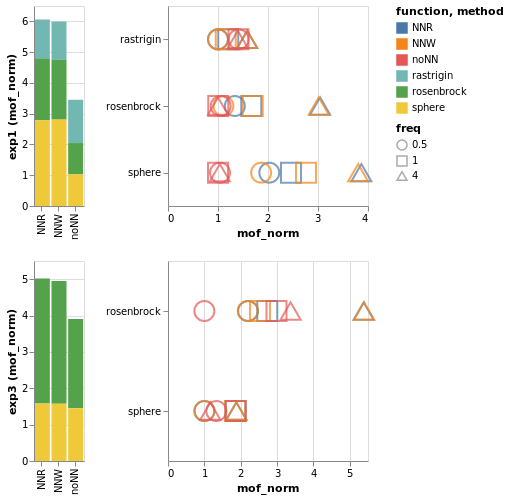

In [21]:
chartworst=(plot_experiment('exp1'))&(plot_experiment('exp3'))
chartworst
# chartworst.save(str(path/'chartworst.png'), scale_factor=2.0)
#|(plot_experiment('exp3'))&(plot_experiment('exp4'))

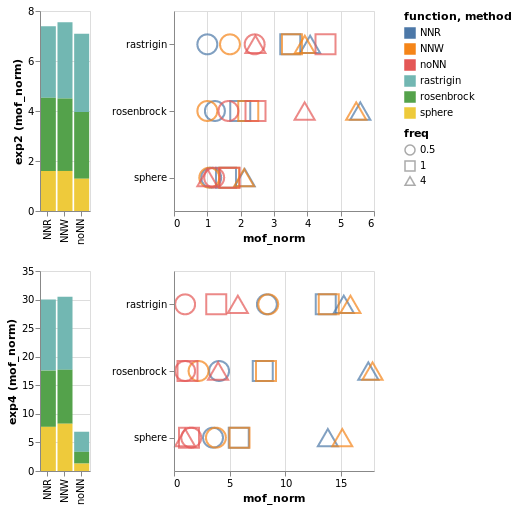

In [22]:
chartbest=(plot_experiment('exp2'))&(plot_experiment('exp4'))
chartbest
# chartbest.save(str(path/'chartbest.png'), scale_factor=2.0)

## plot 2

In [476]:
def plot_exp(exp, axs, colors='method', x_axis='function'):
    test = d.query(f"experiment=={exp!r}").copy()
    mins = test.groupby('function')['mof'].min()
    test['mof_norm'] = test['mof']
    for k,v in mins.iteritems():
        test.loc[test.function==k,'mof_norm'] = test.loc[test.function==k,'mof']/v

    for (f,v),ax in zip(test.groupby('freq'),axs):
        sns.barplot(x=x_axis, y='mof_norm', data=v, hue=colors, ax=ax) #y='mof_norm'
        ax.set_title(f'freq={f}')
        ax.get_legend().remove()
    ax.legend(loc='best', bbox_to_anchor=(1.05, 0.52, 0.5, 0.5))
    for ax in axs[1:]: ax.set_ylabel('')
    for ax in axs: ax.set_xlabel('')

def plot_all_exp(colors='method', x_axis='function'):
    fig,axss = plt.subplots(4, 3, sharey=False, figsize=(10,12))
    for exp,axs in zip(['exp1','exp2','exp3','exp4'],axss): plot_exp(exp, axs, colors, x_axis)
    for axs in axss[1:]:
        for ax in axs: ax.set_title('')
    plt.tight_layout()

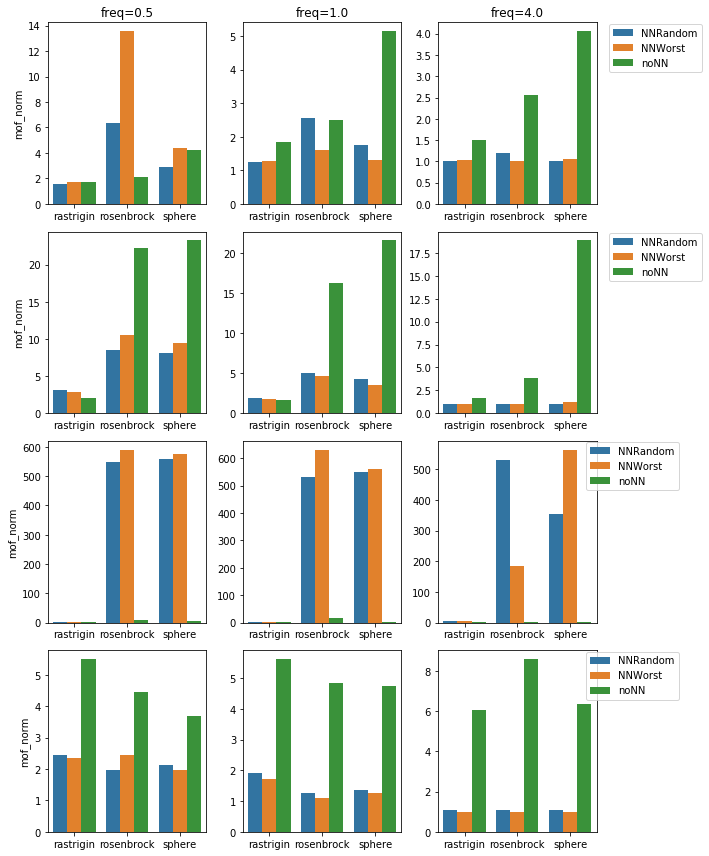

In [501]:
#method versus functions
freqMethod = plot_all_exp(colors='method', x_axis='function')
freqMethod

In [502]:
#freqMethod.save(str(path/'freqMethod.png'), scale_factor=2.0)

AttributeError: 'NoneType' object has no attribute 'save'

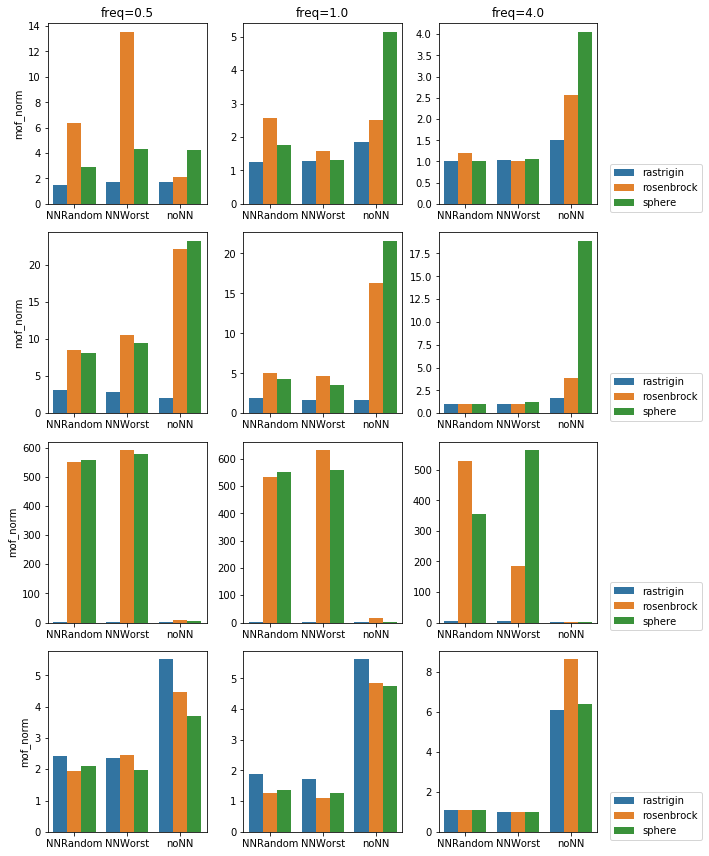

In [459]:
#functions versus methods
plot_all_exp(colors='function', x_axis='method')

# Arr plot

## Read Data

In [9]:
path= Path(f'../../data/cluster_results')

In [10]:
def read_csv(f):
    df = pd.read_csv(f).mean()
    df['std'] = pd.read_csv(f).std().iloc[0] ##added line for std, remove this will remove std from table
    df['experiment'] = f.parent.parent.parent.name
    df['function'] = f.parent.parent.name
    name = f.parent.name
    #print(name)
    df['freq'] = float(name[4:].split('n')[0])
    #print(df['freq'])
    df['method'] = f.name.split('_')[0]+'_'+f.name.split('_')[1]
    #df['method'] = f.name.split('_')[0]
    #print(df['method'])
    return df

measure_name=['mof','sr','arr','nfe','nn_time']
index_measure=2

In [12]:
m = measure_name[index_measure]
files  = list(f for f in path.glob(f'exp*/*/freq*nn_p3nn_s3nn_tw5*bs4*/*{m}.csv') if 'NNnorm' in f.name)
# files += list(path.glob(f'exp*/*/*nn_p3/*{m}.csv'))
files += [f for f in path.glob(f'exp*/*/freq*nn_p3nn_s2nn_tw5*bs4*/*{m}.csv') if 'noNN' in f.name] #f'exp*/*/*nn_p3/*{m}.csv'  , 
#print(files)
df = pd.DataFrame([read_csv(f) for f in files])
df.rename({'0':m}, axis=1, inplace=True)
# data = pd.pivot_table(df, index=['experiment','function'], columns='method', values=m) #,'freq' later for adding frequency experiment
data = pd.pivot_table(df, index=['experiment','function','freq'],  columns='method') #,'freq' later for adding frequency experiment, ,values=m
data.style.format("{:,.2f}")

In [13]:
#to add std to table
final_data = data[m].copy()

for col in data[m].columns:
    final_data[col] = data[m][col].apply(lambda x: f'{x:,.2f} (±') + data['std'][col].apply(lambda x: f'{x:,.2f})')
final_data

method                     NNnorm_Random   NNnorm_Worst noNNReval_arr.csv
experiment function   freq                                               
exp1       rastrigin  0.5   0.03 (±0.00)   0.04 (±0.00)      0.01 (±0.00)
                      1.0   0.08 (±0.05)   0.09 (±0.09)      0.01 (±0.00)
                      4.0   0.17 (±0.09)   0.20 (±0.10)      0.03 (±0.00)
           rosenbrock 0.5   0.18 (±0.02)   0.21 (±0.01)      0.02 (±0.01)
                      1.0   0.31 (±0.12)   0.27 (±0.02)      0.02 (±0.00)
                      4.0   0.42 (±0.10)   0.37 (±0.03)      0.02 (±0.00)
           sphere     0.5   0.28 (±0.02)   0.35 (±0.01)      0.02 (±0.01)
                      1.0   0.50 (±0.02)   0.49 (±0.01)      0.01 (±0.00)
                      4.0   0.65 (±0.02)   0.63 (±0.02)      0.03 (±0.00)
exp2       rastrigin  0.5   0.05 (±0.02)   0.09 (±0.10)      0.18 (±0.16)
                      1.0   1.39 (±5.19)   1.96 (±8.67)      0.13 (±0.07)
                      4.0   0.46 (±0.94)  2.71 (±13.90)      0.13 (±0.05)
           rosenbrock 0.5   0.26 (±0.02)   0.28 (±0.01)      0.26 (±0.04)
                      1.0   0.33 (±0.03)   0.34 (±0.02)      0.31 (±0.05)
                      4.0   0.50 (±0.05)   0.47 (±0.03)      0.38 (±0.01)
           sphere     0.5   0.31 (±0.02)   0.45 (±0.03)      0.44 (±0.09)
                      1.0   0.63 (±0.03)   0.65 (±0.02)      0.48 (±0.09)
                      4.0   0.84 (±0.05)   0.84 (±0.02)      0.53 (±0.20)
exp3       rastrigin  0.5   0.02 (±0.00)   0.02 (±0.00)      0.03 (±0.00)
                      1.0   0.02 (±0.00)   0.02 (±0.00)      0.02 (±0.00)
                      4.0   0.08 (±0.10)   1.00 (±4.65)      0.15 (±0.14)
           rosenbrock 0.5   0.35 (±0.02)   0.38 (±0.01)      0.41 (±0.04)
                      1.0   0.49 (±0.03)   0.50 (±0.03)      0.51 (±0.52)
                      4.0   1.03 (±0.10)   0.99 (±0.06)      1.65 (±0.55)
           sphere     1.0     nan (±nan)    0.65 (±nan)        nan (±nan)
exp4       rastrigin  0.5   0.29 (±0.01)   0.26 (±0.01)      0.05 (±0.03)
                      1.0   0.42 (±0.02)   0.42 (±0.02)      0.09 (±0.15)
                      4.0   0.65 (±0.02)   0.67 (±0.02)      0.11 (±0.08)
           rosenbrock 0.5   0.42 (±0.08)   0.44 (±0.02)      0.50 (±0.22)
                      1.0   0.58 (±0.04)   0.60 (±0.10)      0.36 (±0.10)
                      4.0   0.82 (±0.02)   0.90 (±0.54)      0.40 (±0.59)
           sphere     0.5   0.51 (±0.77)   0.38 (±0.02)      0.39 (±0.04)
                      1.0   0.55 (±0.07)   0.56 (±0.06)      0.26 (±0.04)
                      4.0   0.84 (±0.02)   0.82 (±0.01)      0.12 (±0.11)

## show plots

In [14]:
plot_df = data['arr'].reset_index()
plot_df.rename({'NNnorm_Random':'NNR', 'NNnorm_Worst':'NNW', 'noNNReval_sr.csv':'noNN'}, axis=1, inplace=True)
#plot_df.head()

KeyError: 0.5

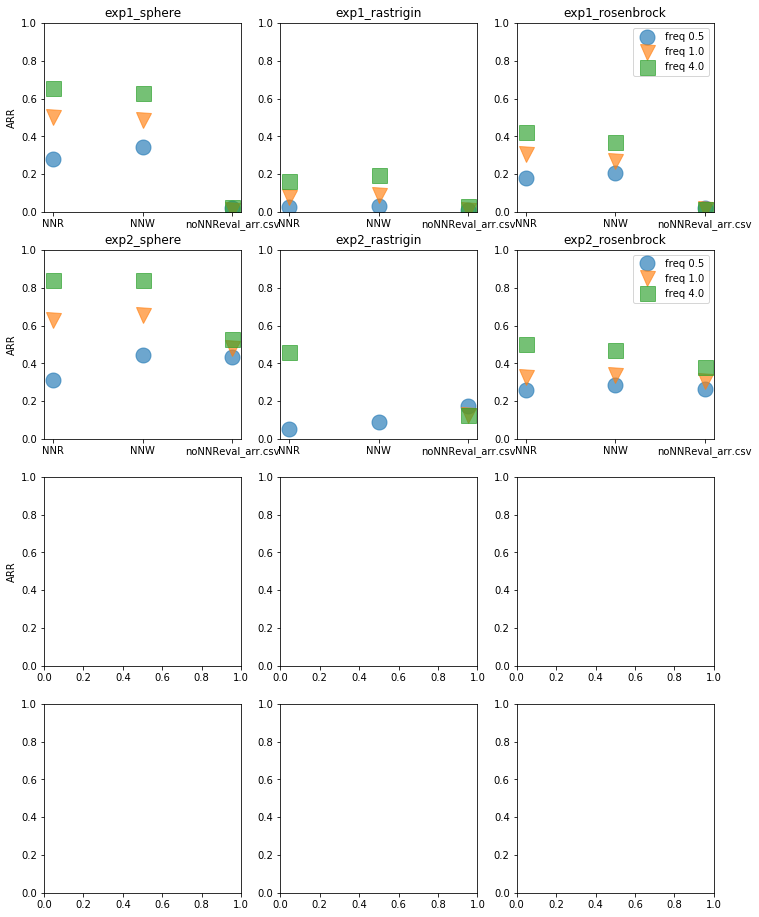

In [15]:
fig,axss = plt.subplots(4, 3, figsize=(12,16))
experiments = ['exp1','exp2','exp3','exp4']
functions = ['sphere','rastrigin','rosenbrock']
freqs = [0.5, 1.0, 4.0]
for exp,axs in zip(experiments,axss):
    axs[0].set_ylabel('ARR')#exp
    for func,ax in zip(functions,axs):
        t = (plot_df[(plot_df.function==func)&(plot_df.experiment==exp)]
                    .drop(['experiment','function'], axis=1)
                    .set_index('freq'))
        for freq,symbol in zip(freqs,['o','v','s']):
            ax.plot(t.loc[freq], symbol, markersize=15, alpha=0.65, label=f'freq {freq:0.1f}')
            
        ax.set_title(f'{exp}_{func}')
        ax.set_ylim(0,1)
    ax.legend()
plt.tight_layout()

### average based on functions

In [16]:
fig,axs = plt.subplots(1, 4, figsize=(14,4))
experiments = ['exp1','exp2','exp3','exp4']
functions = ['sphere','rastrigin','rosenbrock']
freqs = [0.5, 1.0, 4.0]
for exp,ax in zip(experiments,axs):
#     axs[0].set_ylabel(exp)
    t = (plot_df[plot_df.experiment==exp]
                .drop(['experiment'], axis=1)
                .groupby('freq').mean())
    for freq,symbol in zip(freqs,['o','v','s']):
        ax.plot(t.loc[freq], symbol, markersize=15, alpha=0.65, label=f'freq {freq:0.1f}')

    ax.set_title(f'{`zexp}')
    ax.set_ylim(0,1)
axs[-1].legend()
plt.tight_layout()

SyntaxError: invalid syntax (<fstring>, line 1)

In [173]:
t = (plot_df[plot_df.experiment=='exp3']
                .drop(['experiment'], axis=1)
#                 .groupby('freq')
    )

In [174]:
t

method,function,freq,NNR,NNW,noNN
18,rastrigin,0.5,0.023920,0.019520,0.026278
19,rastrigin,1.0,0.019104,0.019256,0.021273
20,rastrigin,4.0,0.086636,0.073897,0.145885
21,rosenbrock,0.5,0.266350,0.236900,0.413824
22,rosenbrock,1.0,0.622255,0.360021,0.509239
23,rosenbrock,4.0,0.929130,0.997276,1.650545
24,sphere,0.5,0.265134,0.237178,NaN
25,sphere,1.0,0.383014,0.371734,NaN
26,sphere,4.0,0.472202,0.820566,NaN


# Final Plot

## functions

In [18]:
col_by_freq = True
col_palette = 'Set3'

def get_files(m):
    files  = list(f for f in path.glob(f'exp*/*/freq*nn_p3nn_s3nn_tw5*bs4*/*{m}.csv') if 'NNnorm' in f.name)
    files += [f for f in path.glob(f'exp*/*/freq*nn_p3nn_s2nn_tw5*bs4*/*{m}.csv') if 'noNN' in f.name]
    return files

def read_csv(f,m):
    df = pd.read_csv(f)
    df['experiment'] = f.parent.parent.parent.name
    df['function'] = f.parent.parent.name
    name = f.parent.name
    df['freq'] = float(name[4:].split('n')[0])
    df['method'] = f.name.split('_')[0]+'_'+f.name.split('_')[1]
#     df['method'] = f.name.split('_')[0]
    df.rename({'0':m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df

def get_data(m, normalize=False):
    short_dict = {'NNnorm_Random':'NNR', 'NNnorm_Worst':'NNW', 'noNNReval_sr.csv':'noNN',
                  'noNNReval_arr.csv':'noNN', 'noNNReval_mof.csv':'noNN'}
    files = get_files(m)
    data = pd.concat([read_csv(f,m) for f in files])
    data.method = data.method.apply(lambda x: short_dict[x])
    if normalize:
        data_norm = (data.groupby(['experiment','function','freq','method'])[m.upper()].mean().reset_index()
                         .groupby(['experiment','function'])[m.upper()].min().reset_index()
                         .rename({m.upper():m.upper()+'_norm'}, axis=1))
        data = data.merge(data_norm, 'left')
        data[m.upper()+'_norm'] = data[m.upper()] / data[m.upper()+'_norm']
    return data

def plot_one(data, m, normalize=False, title='', title_size=14, col_by_freq=col_by_freq, col_palette=col_palette,
             legend=False, hide_x=True, hide_y=True, ax=None, do_lim=True, ll=0.2, ul=0.8):
    m = m.upper()
    if normalize: m = m + '_norm' 
    if ax is None: fig,ax = plt.subplots(1,1,figsize=(6,4))
    sns.boxplot('method' if col_by_freq else 'freq', m, hue='freq' if col_by_freq else 'method',
                data=data, palette=col_palette,
                # width=2.5,
                linewidth=0.5, fliersize=0, ax=ax)
    if not legend: ax.get_legend().remove()
    if do_lim:
        ax.set_ylim(-0.05,1.05)
    else:
        g = data.groupby(['method','freq'])[m]
        q1,q3 = g.quantile(ll),g.quantile(ul)
        iqr = q3-q1
        lower_lim = (q1 - 1.5*iqr).min()
        upper_lim = (q3 + 1.5*iqr).max()
        lower_lim = data[m][data[m]>=lower_lim].min()
        upper_lim = data[m][data[m]<=upper_lim].max()
        ax.set_ylim(lower_lim,upper_lim)
        
    ax.set_xlabel('')
    if hide_x: ax.set_xticklabels([])
    if hide_y: ax.set_ylabel('')
    ax.set_title(title, size=title_size)
    return ax

def plot_all(m, normalize=False, title_size=12, col_by_freq=col_by_freq, col_palette=col_palette, do_lim=True,
             ll=0.2, ul=0.8):
    data = get_data(m, normalize=normalize)
    fig,axss = plt.subplots(4, 3, figsize=(14,16), sharex=do_lim, sharey=do_lim)
    for i,(axs,exp) in enumerate(zip(axss,['exp1','exp2','exp3','exp4'])):
        first_exp = i==0
        for j,(ax,func) in enumerate(zip(axs,['sphere', 'rosenbrock', 'rastrigin'])):
            first_func = j==0
            test = data.query(f'experiment=={exp!r} and function=={func!r}')
            plot_one(test, m, normalize=normalize, title=f'{exp}-{func.title()}', title_size=title_size, hide_x=False,
                     hide_y=not first_func, col_by_freq=col_by_freq, col_palette=col_palette, ax=ax,
                     do_lim=do_lim, ll=ll, ul=ul)
        ax.legend(loc='upper left', ncol=3)
    plt.tight_layout()
    return fig,axss

## Plots

In [3]:
path= Path(f'../../data/cluster_results')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


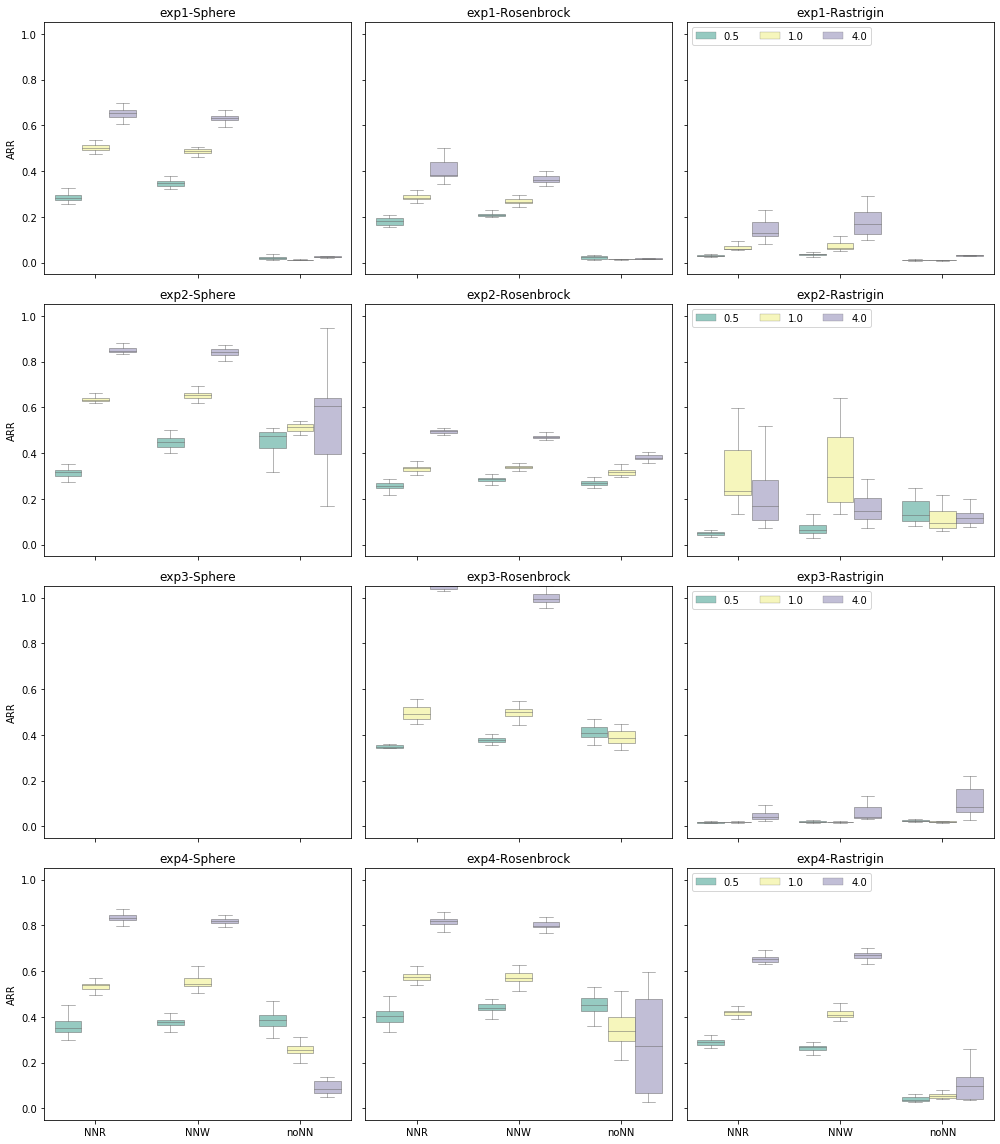

In [23]:
fig,axs = plot_all('arr', title_size=12, col_by_freq=True, col_palette='Set3')
fig.savefig(path/'ARR.eps', dpi=400, format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


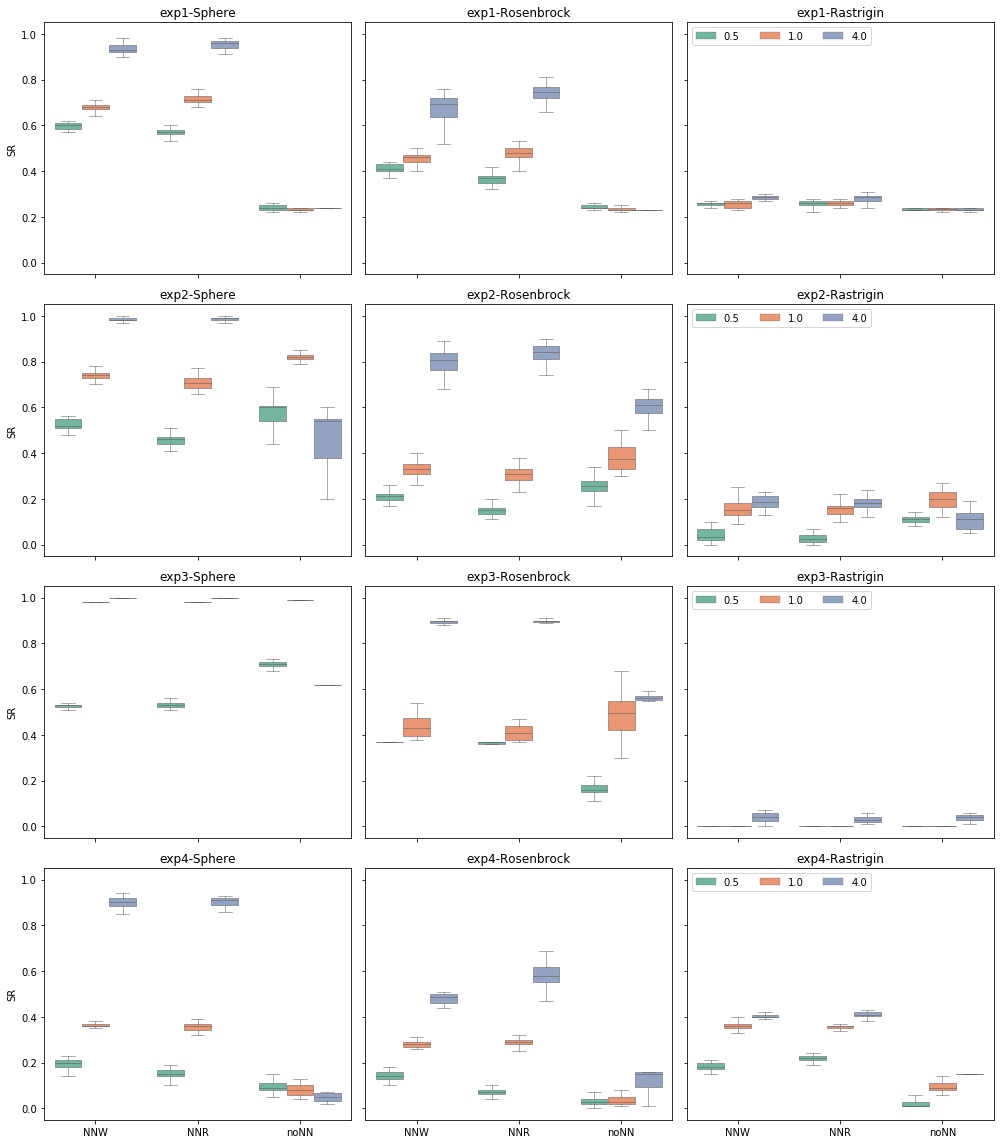

In [24]:
fig,axs = plot_all('sr', title_size=12, col_by_freq=True, col_palette='Set2')
fig.savefig(path/'SR.eps', dpi=400, format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


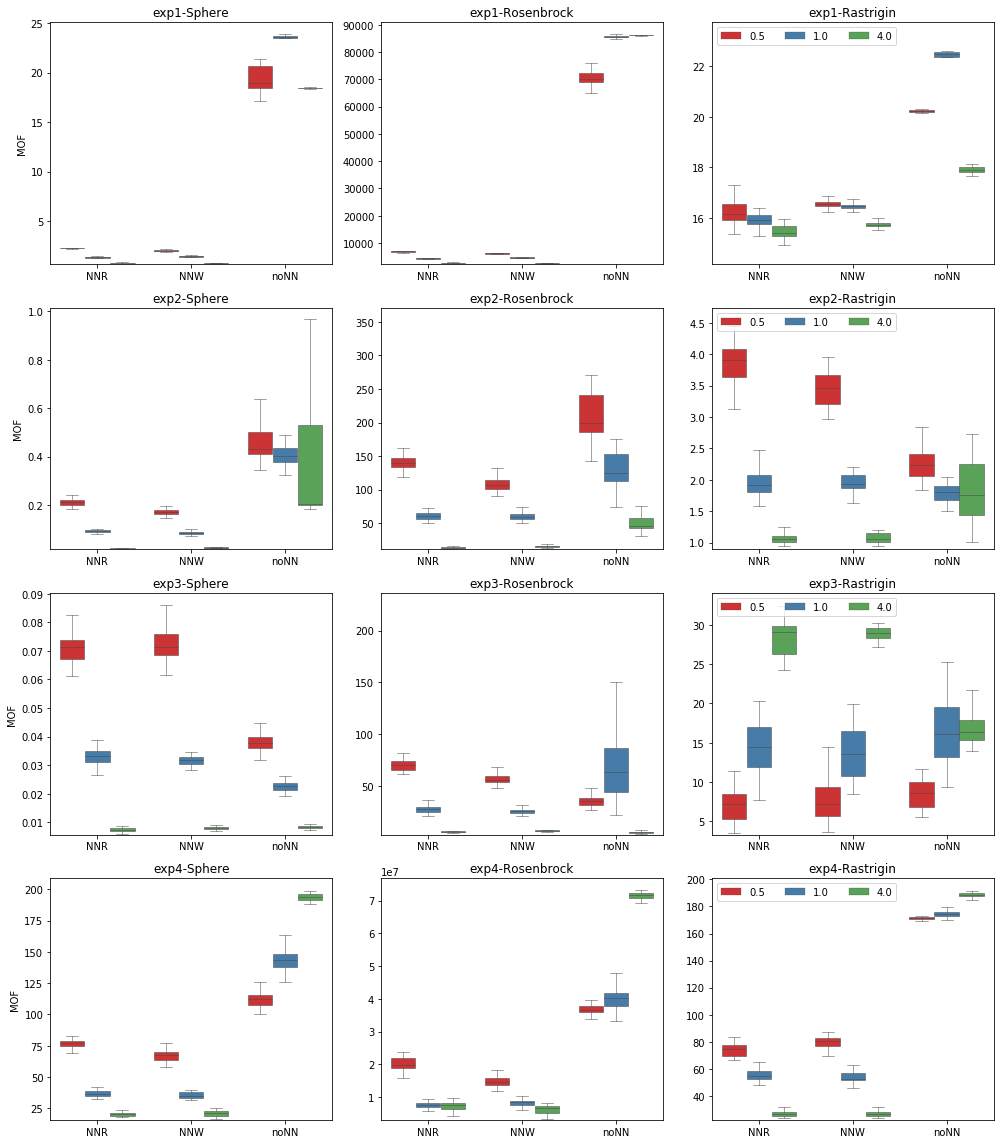

In [25]:
fig,axs = plot_all('mof', title_size=12, col_by_freq=True, col_palette='Set1', do_lim=False, ll=0.2, ul=0.8)
for ax in axs.flatten():
    ll,ul = ax.get_ylim()
    ax.set_ylim(ll*0.95, ul*1.05)
    
fig.savefig(path/'MOF.eps', dpi=400, format='eps')

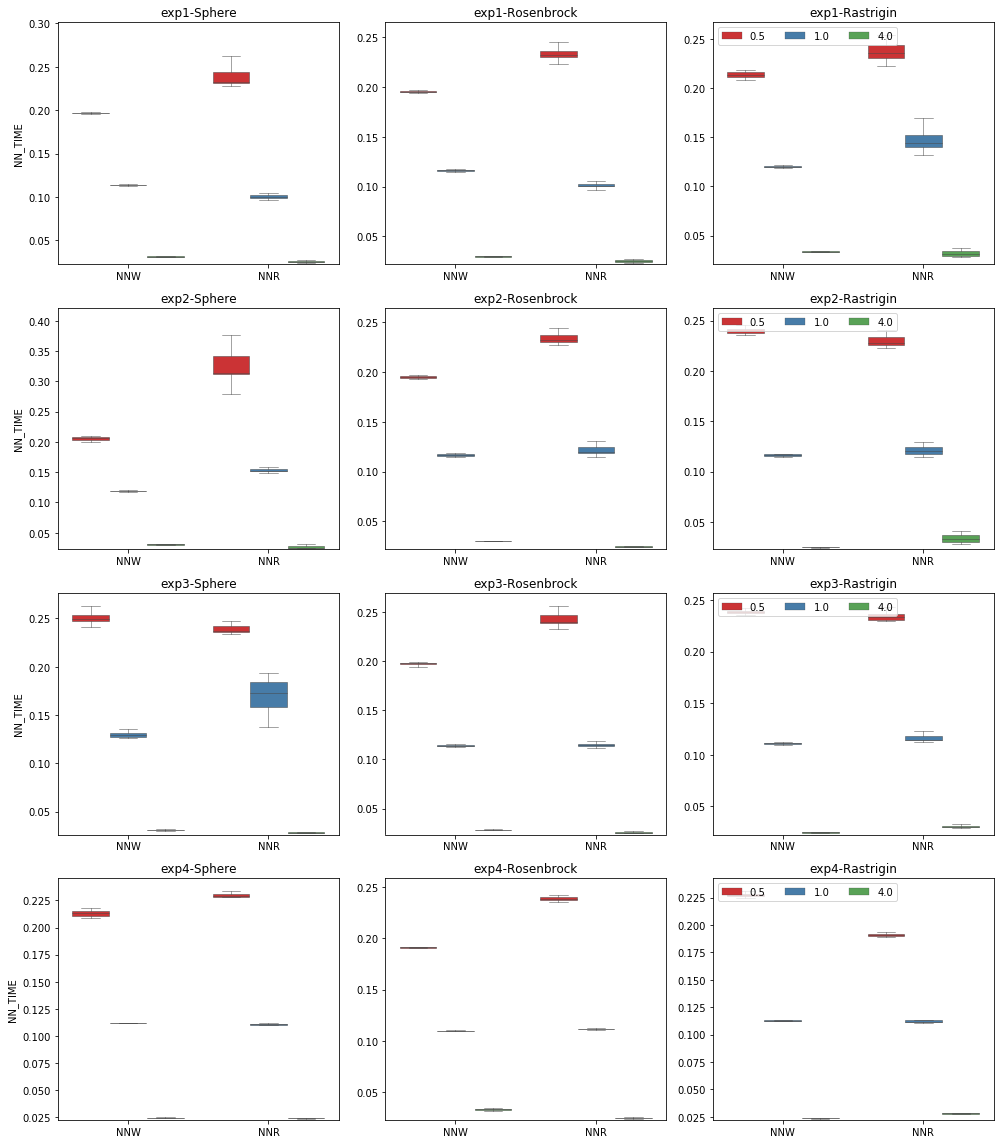

In [22]:
fig,axs = plot_all('nn_time', title_size=12, col_by_freq=True, col_palette='Set1', do_lim=False, ll=0.2, ul=0.8)
for ax in axs.flatten():
    ll,ul = ax.get_ylim()
    ax.set_ylim(ll*0.95, ul*1.05)
    
fig.savefig(path/'nntime.eps', dpi=400, format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


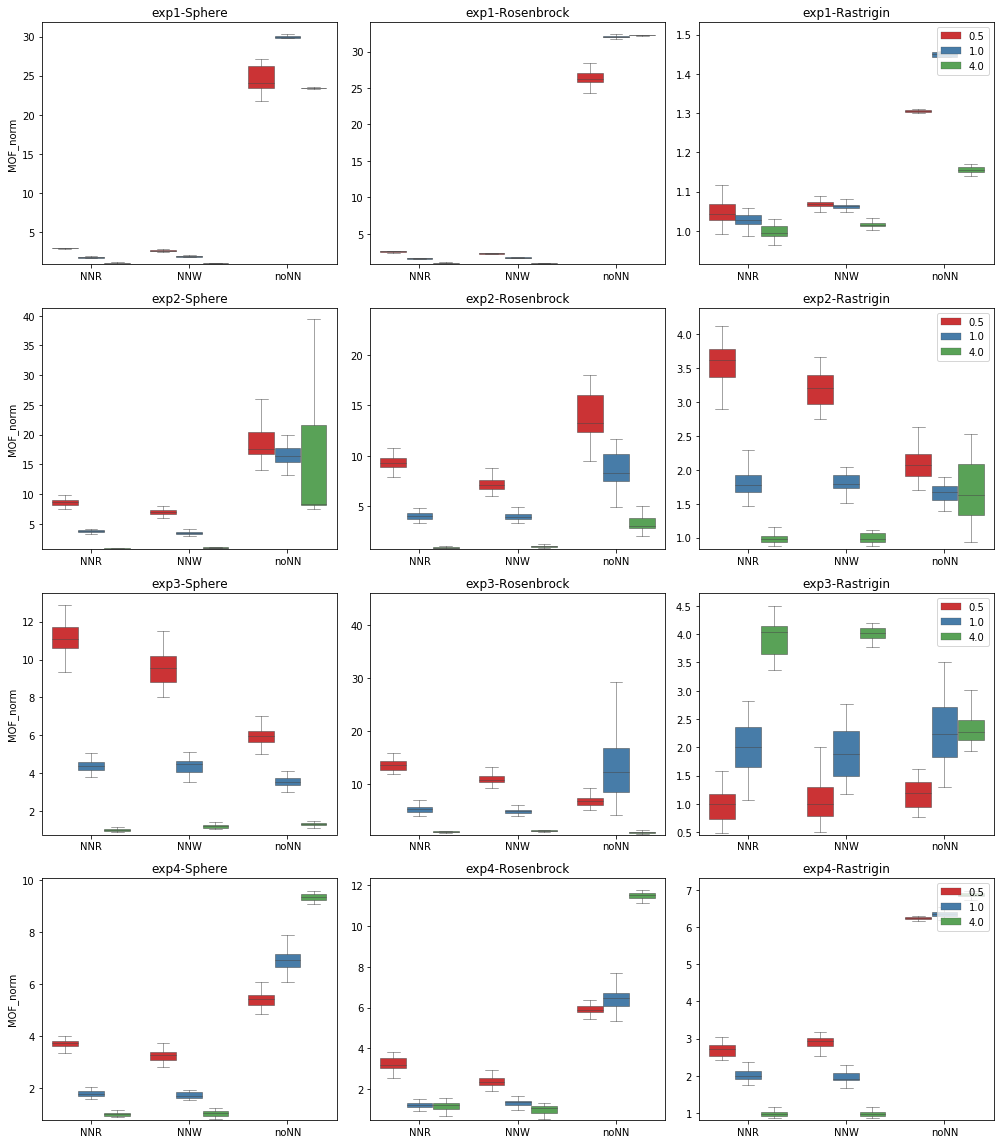

In [13]:
# This if for normalize MOF values
fig,axs = plot_all('mof', normalize=True, title_size=12, col_by_freq=True, col_palette='Set1', do_lim=False,
                   ll=0.2, ul=0.8)
for ax in axs.flatten():
    ll,ul = ax.get_ylim()
    ax.set_ylim(ll*0.95, ul*1.05)
    
fig.savefig(path/'MOFnorm.eps', dpi=400, format='eps')

In [14]:
get_data('mof').query("experiment == 'exp3' and freq==1").groupby(['function','freq','method']).mean()

MOF
function   freq method           
rastrigin  1.0  NNR     14.372871
                NNW     13.593602
                noNN    16.687152
rosenbrock 1.0  NNR     27.425770
                NNW     25.805042
                noNN    78.056529
sphere     1.0  NNR      0.027937
                NNW      0.028012
                noNN     0.022568

In [15]:
get_data('arr').query("experiment == 'exp3'").groupby(['function','freq','method']).mean()

ARR
function   freq method          
rastrigin  0.5  NNR     0.019205
                NNW     0.020285
                noNN    0.026278
           1.0  NNR     0.020023
                NNW     0.019732
                noNN    0.021273
           4.0  NNR     0.076695
                NNW     1.002755
                noNN    0.145885
rosenbrock 0.5  NNR     0.353291
                NNW     0.376411
                noNN    0.413824
           1.0  NNR     0.494028
                NNW     0.501292
                noNN    0.509239
           4.0  NNR     1.028719
                NNW     0.988412
                noNN    1.650545
sphere     0.5  NNR          NaN
                NNW          NaN
                noNN         NaN
           1.0  NNR          NaN
                NNW     0.650586
                noNN         NaN
           4.0  NNR          NaN
                NNW          NaN
                noNN         NaN

# ----